Zakarya Ali  
Python pour un data scientist 2A - Xavier Dupré  
[Kaggle Competition - Porto Seguro's Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction)  

# Introduction
Porto Seguro is a Brazilian insurance company. One of its most important market is the driver insurance. This is a sector where it is quite difficult to assess with certainty which customer will soon file an insurance claim. In order to better its insurance claim predictions, the company launched a Kaggle competition whose winner will not only win a 25000$ prize, but will be able to implement his/her idea.  
In this notebook, we aim at analyzing the dataset delivered by the brazilian company, and implementing a machine learning model to predict the insurance claims.

In [1]:
#We import the Python modules we will use in this notebook
%matplotlib inline
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from tqdm import tqdm
import psutil
import os
import logging
import sys
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import CondensedNearestNeighbour
from collections import Counter
from sklearn import metrics
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
import missingno

# Dataset Analysis
Let's analyze the training dataset.

In [2]:
train_dir = "data/train/"
train = pd.read_csv(train_dir + "train.csv", sep=",", encoding="utf8", low_memory=False)
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
train.drop_duplicates().shape

(595212, 59)

59 columns and almost 600000 observations with no duplicated lines. All the columns represent numeric values.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

## Features
We don't have much information regarding the features. None of them are described. The [competition data presentation](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data) only gives a brief introduction.  
- 'id' column : id of the observation
- 'target' column : 1 if the observation concerns an insurance claim 0 if not. This is the column to predict

Features whose names contain :
- 'bin' are binary features 
- 'cat' are categorical features  

On top of it, we assume :
- integer variables are ordinal variable
- float64 variables are numeric one


In [5]:
binary = []
categorical = []
ordinal = []
numeric = []

for c in train.columns:
    if ('bin' in c):
        binary.append(c)
    if 'cat' in c:
        categorical.append(c)
    if ('bin' not in c) & ('cat' not in c) & (c in train.dtypes[train.dtypes=='int64']) & (c not in ['target', 'id']):
        ordinal.append(c)
    if ('bin' not in c) & ('cat' not in c) & (c in train.dtypes[train.dtypes=='float64']):
        numeric.append(c)

In [6]:
#Checking the features categories
print('Binary columns :' + ", ".join(str(x) for x in binary))
print('')
print('Categorical columns :' + ", ".join(str(x) for x in categorical))
print('')
print('Ordinal columns :' + ", ".join(str(x) for x in ordinal))
print('')
print('Numeric columns :' + ", ".join(str(x) for x in numeric))

Binary columns :ps_ind_06_bin, ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin, ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin, ps_ind_16_bin, ps_ind_17_bin, ps_ind_18_bin, ps_calc_15_bin, ps_calc_16_bin, ps_calc_17_bin, ps_calc_18_bin, ps_calc_19_bin, ps_calc_20_bin

Categorical columns :ps_ind_02_cat, ps_ind_04_cat, ps_ind_05_cat, ps_car_01_cat, ps_car_02_cat, ps_car_03_cat, ps_car_04_cat, ps_car_05_cat, ps_car_06_cat, ps_car_07_cat, ps_car_08_cat, ps_car_09_cat, ps_car_10_cat, ps_car_11_cat

Ordinal columns :ps_ind_01, ps_ind_03, ps_ind_14, ps_ind_15, ps_car_11, ps_calc_04, ps_calc_05, ps_calc_06, ps_calc_07, ps_calc_08, ps_calc_09, ps_calc_10, ps_calc_11, ps_calc_12, ps_calc_13, ps_calc_14

Numeric columns :ps_reg_01, ps_reg_02, ps_reg_03, ps_car_12, ps_car_13, ps_car_14, ps_car_15, ps_calc_01, ps_calc_02, ps_calc_03


## Missing values
Some observations have missing information.
From the [competition data presentation](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data), we know missing values are noted "-1". We can find them using [missingno](https://github.com/ResidentMario/missingno), a missing data vizualisation module for Python.

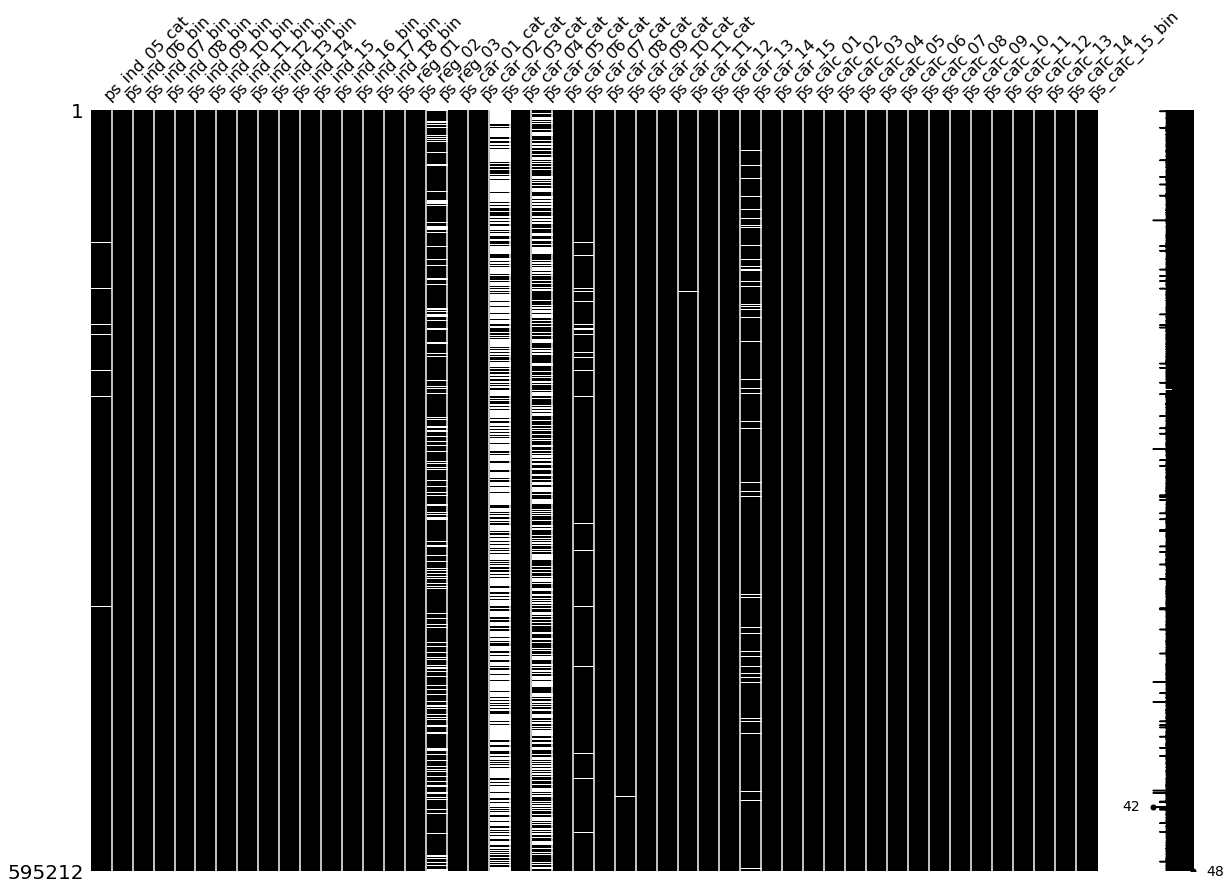

In [7]:
# Missing values by columns
missingno.matrix(df=train.replace(-1, np.NaN).iloc[:,6:54], figsize=(20, 14), color=(0, 0, 0))

As we can see, a few columns have missing values. To be more specific:

In [8]:
incomplete = train.columns[train.eq(-1).any()]

#proportion of missing values for each column
cols_to_fix_w_mean=[]
for c in incomplete:
    missings_values = train[train[c] == -1][c].count()
    missings_perc = missings_values.astype(np.float32)/train.shape[0]*100
    print(str(c) + ' has ' + str(np.round(missings_perc, 3)) + '% missing values')
    if missings_perc<20:
        cols_to_fix_w_mean.append(c)

ps_ind_02_cat has 0.036% missing values
ps_ind_04_cat has 0.014% missing values
ps_ind_05_cat has 0.976% missing values
ps_reg_03 has 18.106% missing values
ps_car_01_cat has 0.018% missing values
ps_car_02_cat has 0.001% missing values
ps_car_03_cat has 69.09% missing values
ps_car_05_cat has 44.783% missing values
ps_car_07_cat has 1.93% missing values
ps_car_09_cat has 0.096% missing values
ps_car_11 has 0.001% missing values
ps_car_12 has 0.0% missing values
ps_car_14 has 7.16% missing values


The two columns **ps_car_03_cat** and **ps_car_03_cat** have missing values rates higher than 40%. We should drop them as they don't give enough information. We'll see how to handle other features with fewer missing values in the dateset treatment section.

## Imbalanced Dataset
By checking the "target" column, we want to see how the dataset is balanced, meaning what is the ratio of insurance claims within the observations. 

In [9]:
target_group = train.groupby(['target']).size()
target_count = target_group.to_frame()
target_count = target_count.reset_index()
target_count = target_count.rename({0: "count"}, axis='columns')
target_count

,target,count
0,0,573518
1,1,21694


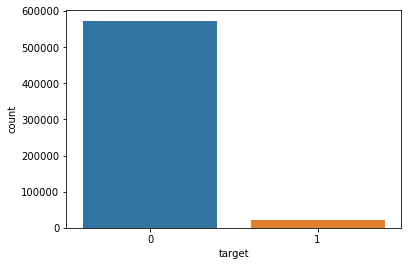

In [10]:
#Target visualization
ax = sns.barplot(x="target", y="count", data=target_count, ci=None)

In [11]:
np.mean(train["target"]) #Rate of 1 in the 'target' column

0.036447517859182946

We have only about 4% of filed claims for that policy holder. This is a highly imbalanced dataset. This is not surprising since people don't change file insurance every year. In general, they do so when they acquire a new vehicle. Since the percentage of file claims is very low, we can understand why the company is having a hard time predicting it.

"""
We need to **oversample** values leading to **target=1**  
or **undersample** the other ones  
We choose the first method
""""

## Dataset treatment
### Treating missing variables

# Model Building

# Conclusion

# Sources